### Prepare Data

In [ ]:
from glob import glob
from ConceptMining import ConceptMiner
from settings import settings

import pickle

In [ ]:
batch_size = 70
images = [i for i in glob("../dataset/Images/*.jpg")]
Miner = ConceptMiner(images = images, load_model= True)

# encodings, captions = Miner.get_image_caption(get_encodings = True, batch_size = batch_size)

In [ ]:
# with open('encodings.pkl', 'wb') as f:
#     pickle.dump({'encodings':encodings, 'captions': captions}, f)
with open('encodings.pkl', 'rb') as f:
	data = pickle.load(f)
	encodings = data['encodings']
	captions = data['captions']

In [ ]:
concept_model, generated_concepts = Miner.concept_modeling(encodings = encodings, 
                                                           captions = captions, 
                                                           batch_size = batch_size)

with open("generated_concepts.pkl", "wb") as f:
    pickle.dump(generated_concepts, f)


### Cluser topics by semantic similarity 
- Cluser concepts
- Sample concepts taking as mean the centroid +- a random noice to simulate user externalization

In [8]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from umap import UMAP
import os, pickle
import numpy as np

from transformers import AutoTokenizer, AutoModel

with open("generated_concepts.pkl", "rb") as f:
    generated_concepts = list(set(pickle.load(f)) - {""})
    
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")
model = AutoModel.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")

In [9]:
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn.functional as F

def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

def get_embedding(sentences, model, tokenizer, batch_size = 16):
    with torch.no_grad():

        output = None
        for i in range(0, len(sentences), batch_size):
            encoded_input = tokenizer(sentences[i: i + batch_size], padding=True, return_tensors='pt')

            model_output = model(**encoded_input)
            sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

            sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1)
            output = sentence_embeddings if output is None else torch.cat([output, sentence_embeddings])

    return output

concepts_embeddings = get_embedding(generated_concepts, model, tokenizer, batch_size = 16)

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA

similarity_matrix = cosine_similarity(concepts_embeddings)

# Apply Spectral Clustering
num_clusters = 20
spectral = SpectralClustering(n_clusters=num_clusters, affinity='precomputed', random_state=42)
labels = spectral.fit_predict(similarity_matrix)

# Group words by topic
topic_groups = {}
for word, cluster in zip(generated_concepts, labels):
    topic_groups.setdefault(cluster, []).append(word)
    
with open("generated_concepts.pkl", "wb") as f:
	pickle.dump({'concepts':generated_concepts,
              'topic_groups': topic_groups}, f)

#### Preprocess the data for simulation


In [1]:
import pickle
from glob import glob

import random

with open("generated_concepts.pkl", "rb") as f:
	data = pickle.load(f)
	generated_concepts = data['concepts']
	topic_groups = data['topic_groups']

with open('encodings.pkl', 'rb') as f:
	data = pickle.load(f)
	encodings = data['encodings']
	captions = data['captions']

images = [i for i in glob("../dataset/Images/*.jpg")]

In [2]:
concept_instance = {i:[] for i in generated_concepts}

for i, path in enumerate(images):
	for c in captions[i].split():
		if c in generated_concepts:
			concept_instance[c] += [path]

remove_topics = []
for i in topic_groups:
	remove = [j for j in topic_groups[i] if len(concept_instance[j]) < 10]
	for j in remove:
		topic_groups[i].remove(j)
	print(f"Topic {i}:", len(topic_groups[i]))
	if len(topic_groups[i]) < 8:
		remove_topics.append(i)

for i in remove_topics:
	del topic_groups[i]

Topic 3: 16
Topic 1: 28
Topic 0: 12
Topic 11: 24
Topic 13: 14
Topic 2: 7
Topic 9: 8
Topic 5: 20
Topic 4: 13
Topic 6: 7
Topic 8: 18
Topic 16: 15
Topic 18: 5
Topic 7: 8
Topic 19: 15
Topic 12: 8
Topic 17: 16
Topic 14: 9
Topic 10: 0
Topic 15: 7


Text(0.5, 0, 'Concepts')

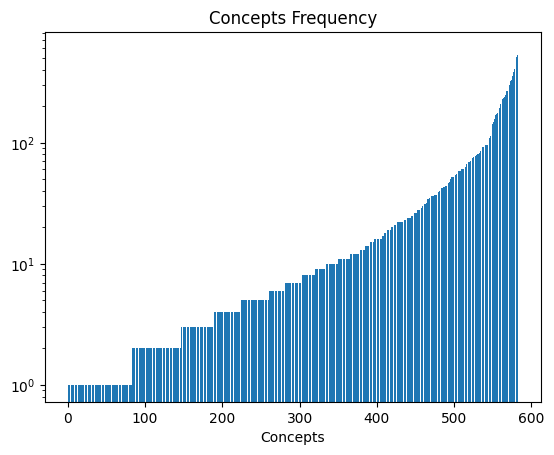

In [3]:
from matplotlib import pyplot as plt	
plt.bar(range(len(generated_concepts)), sorted([len(i) for i in concept_instance.values()]), log = True)
plt.title("Concepts Frequency")
plt.xlabel("Concepts")

Text(0.5, 0, 'Topics')

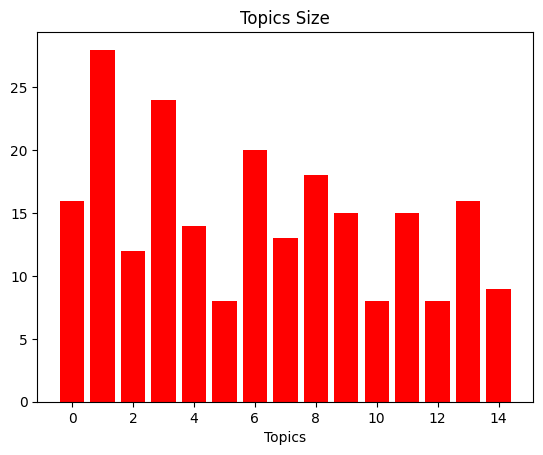

In [4]:
plt.bar(range(len(topic_groups)), [len(topic_groups[i]) for i in topic_groups], color = 'r')
plt.title("Topics Size")
plt.xlabel("Topics")

In [ ]:
import gymnasium as gym
from matplotlib import pyplot as plt

from ConceptPrompting import AdaptationEngine
from tqdm import tqdm
import torch


def encode_actions(action, n_actions):

	if not isinstance(action, torch.Tensor):
		action = torch.tensor(action)
	return torch.nn.functional.one_hot(action, num_classes=n_actions).float()

def preprocess_state(state):
	return torch.tensor(state).float().reshape(1, -1)

def get_entropy(preferences):
	return -torch.sum(preferences * torch.log(preferences), dim = -1)

episodes = 400
episode_length = 1000
dataset_coverage_step = .75
gamma = 0.99
buffer = []
actions_embedd_dim = 2
buffer_size = 512

lr_actor = 0.001
lr_critic = 0.0001

temperature = 2.0
final_temperature = 0.1
decay_rate = 0.99  # Decay per episode

# env = gym.make('MountainCar-v0')
env = gym.make('CartPole-v1')

# Pi = Actor(state_dim = env.observation_space.shape[0], action_dim = actions_embedd_dim, lr_optimizer = lr_actor)
# V = Critic(state_dim = env.observation_space.shape[0], lr_optimizer = lr_critic)
Agent = AdaptationEngine(state_dim = env.observation_space.shape[0],
						 	action_dim=env.action_space.n,
							lr_actor = lr_actor,
							lr_critic = lr_critic,
							gamma = gamma,
							buffer_size = buffer_size,
							sample_temperature = temperature,
							final_temperature = final_temperature,
							temperatura_decay = decay_rate)

actions_encode = encode_actions([i  for i in range(env.action_space.n)], env.action_space.n).to(Agent.device)

episode_history = {'rewards': [],
		    'loss_critic': [], 
			'loss_actor': []}

history = {'rewards': [],
		    'loss_critic': [], 
			'loss_actor': []}


for episode in range(episodes):

	prev_state, _ = env.reset()
	prev_state = preprocess_state(prev_state)

	episode_history = {'rewards': [],
		'loss_critic': [], 
		'loss_actor': [],
		'entropy': []}
			
	itera = tqdm(range(episode_length))
	itera.set_description(f"Episode {episode}")
	
	for step in itera:

		preferences = Agent.policy(prev_state, actions_encode)	
		action = torch.multinomial(preferences, 1).squeeze(-1)
		
		state, reward, done, truncated, _ = env.step(action.item())
		state = preprocess_state(state)

		Agent.push_buffer(state=prev_state,
					 action=action, 
					 reward=reward, 
					 next_state=state, 
					 done=done)
		
		episode_history['rewards'].append(reward)
		episode_history['entropy'].append(get_entropy(preferences).mean().item())

		if Agent.buffer_size <= len(Agent.buffer):
			actor_loss, critic_loss = Agent.optimization_step(actions_encode)
			episode_history['loss_critic'].append(critic_loss)
			episode_history['loss_actor'].append(actor_loss)

		prev_state = state

		itera.set_postfix({'Temperature': f'{temperature:.4f}',
						'Reward': sum(episode_history['rewards']),
						'entropy': sum(episode_history['entropy']),
						'Loss Critic': sum(episode_history['loss_critic']),
						'Loss Actor': sum(episode_history['loss_actor'])} )
		if done or truncated:
			history['rewards'].append(sum(episode_history['rewards']))
			history['loss_critic'].append(sum(episode_history['loss_critic']))
			history['loss_actor'].append(sum(episode_history['loss_actor']))
			break

	temperature = max(final_temperature, temperature * decay_rate)
	if Agent.max_reward is None or Agent.max_reward < sum(episode_history['rewards']):
		Agent.max_reward = sum(episode_history['rewards'])
		Agent.Actor.save(f"actor.pt")
		Agent.Critic.save(f"critic.pt")

env.close()

Text(0.5, 0, 'Iterations')

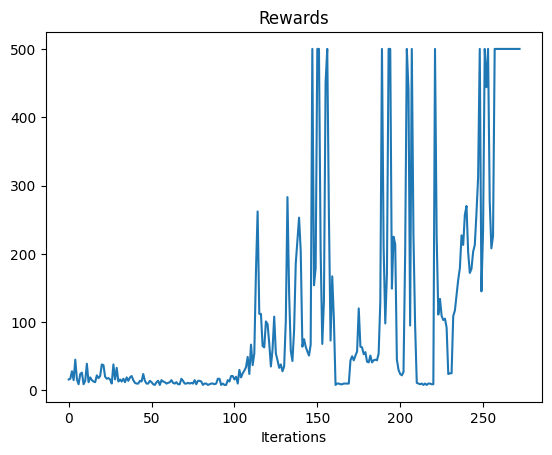

In [2]:
plt.plot(history['rewards'])
plt.title("Rewards")
plt.xlabel("Iterations")

In [45]:
sum(episode_history['rewards'])

-845.0

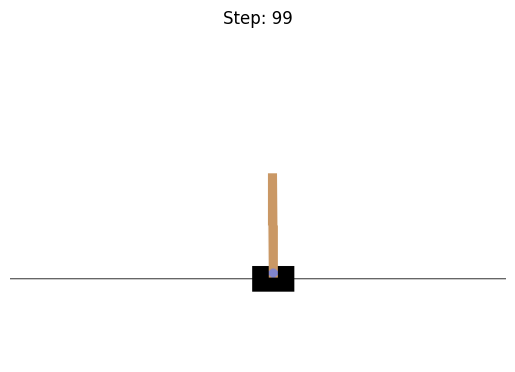

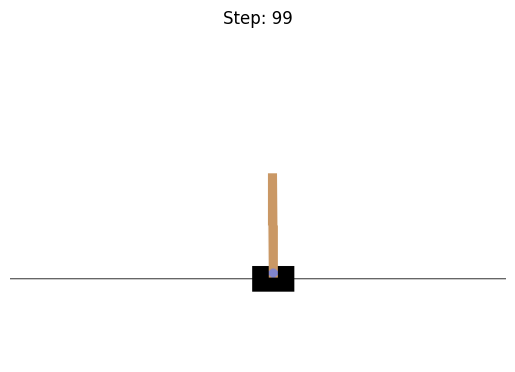

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display

def show_state(env, step=0):
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render())
    plt.title(f"Step: {step}")
    plt.axis('off')

    display.clear_output(wait=True)
    display.display(plt.gcf())


env = gym.make('CartPole-v1', render_mode='rgb_array')
Agent = AdaptationEngine(state_dim = env.observation_space.shape[0],
							action_dim=env.action_space.n)
                            
Agent.Actor.load('actor.pt')
# env = gym.make('MountainCar-v0', render_mode='rgb_array')

prev_state, info = env.reset()
prev_state = preprocess_state(prev_state)
print(prev_state)
for step in range(int(100)):
	preferences =  Agent.policy(prev_state, actions_encode)

	action = preferences.argmax()

	observation, reward, terminated, _, _ = env.step(action.item())
	print(action)

	prev_state = preprocess_state(observation)
	prev_action = action

	show_state(env, step=step)

	if terminated:
		print(observation)
		break

env.close()


### Exploration Agent

In [ ]:
import gymnasium as gym
from matplotlib import pyplot as plt

from ConceptPrompting import AdaptationEngine
from tqdm import tqdm
import torch


def encode_actions(action, n_actions):

	if not isinstance(action, torch.Tensor):
		action = torch.tensor(action)
	return torch.nn.functional.one_hot(action, num_classes=n_actions).float()

def preprocess_state(state):
	return torch.tensor(state).float().reshape(1, -1)

def get_entropy(preferences):
	return -torch.sum(preferences * torch.log(preferences), dim = -1)

episodes = 400
episode_length = 1000
dataset_coverage_step = .75
gamma = 0.99
buffer = []
actions_embedd_dim = 2
buffer_size = 512

lr_actor = 0.001
lr_critic = 0.0001

temperature = 2.0
final_temperature = 0.1
decay_rate = 0.99  # Decay per episode

# env = gym.make('MountainCar-v0')
env = gym.make('CartPole-v1')

# Pi = Actor(state_dim = env.observation_space.shape[0], action_dim = actions_embedd_dim, lr_optimizer = lr_actor)
# V = Critic(state_dim = env.observation_space.shape[0], lr_optimizer = lr_critic)
Agent = AdaptationEngine(state_dim = env.observation_space.shape[0],
						 	action_dim=env.action_space.n,
							lr_actor = lr_actor,
							lr_critic = lr_critic,
							gamma = gamma,
							buffer_size = buffer_size,
							sample_temperature = temperature,
							final_temperature = final_temperature,
							temperatura_decay = decay_rate)

actions_encode = encode_actions([i  for i in range(env.action_space.n)], env.action_space.n).to(Agent.device)

episode_history = {'rewards': [],
		    'loss_critic': [], 
			'loss_actor': []}

history = {'rewards': [],
		    'loss_critic': [], 
			'loss_actor': []}


for episode in range(episodes):

	prev_state, _ = env.reset()
	prev_state = preprocess_state(prev_state)

	episode_history = {'rewards': [],
		'loss_critic': [], 
		'loss_actor': [],
		'entropy': []}
			
	itera = tqdm(range(episode_length))
	itera.set_description(f"Episode {episode}")
	
	for step in itera:

		preferences = Agent.policy(prev_state, actions_encode)	
		action = torch.multinomial(preferences, 1).squeeze(-1)
		
		state, reward, done, truncated, _ = env.step(action.item())
		state = preprocess_state(state)

		Agent.push_buffer(state=prev_state,
					 action=action, 
					 reward=reward, 
					 next_state=state, 
					 done=done)
		
		episode_history['rewards'].append(reward)
		episode_history['entropy'].append(get_entropy(preferences).mean().item())

		if Agent.buffer_size <= len(Agent.buffer):
			actor_loss, critic_loss = Agent.optimization_step(actions_encode)
			episode_history['loss_critic'].append(critic_loss)
			episode_history['loss_actor'].append(actor_loss)

		prev_state = state

		itera.set_postfix({'Temperature': f'{temperature:.4f}',
						'Reward': sum(episode_history['rewards']),
						'entropy': sum(episode_history['entropy']),
						'Loss Critic': sum(episode_history['loss_critic']),
						'Loss Actor': sum(episode_history['loss_actor'])} )
		if done or truncated:
			history['rewards'].append(sum(episode_history['rewards']))
			history['loss_critic'].append(sum(episode_history['loss_critic']))
			history['loss_actor'].append(sum(episode_history['loss_actor']))
			break

	temperature = max(final_temperature, temperature * decay_rate)
	if Agent.max_reward is None or Agent.max_reward < sum(episode_history['rewards']):
		Agent.max_reward = sum(episode_history['rewards'])
		Agent.Actor.save(f"actor.pt")
		Agent.Critic.save(f"critic.pt")

env.close()